In [99]:
import os
import re
import json
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression   
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve

In [100]:
df = pd.read_csv('mobile_data.csv')

In [101]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5910 non-null   object 
 1   brand             5910 non-null   object 
 2   2G                5910 non-null   bool   
 3   3G                5910 non-null   bool   
 4   4G                5910 non-null   bool   
 5   5G                5910 non-null   bool   
 6   Announced         5839 non-null   object 
 7   Status            5910 non-null   object 
 8   Weight            5598 non-null   float64
 9   Length            5903 non-null   object 
 10  Width             5795 non-null   object 
 11  Diameter          5792 non-null   float64
 12  SIM               3984 non-null   object 
 13  Display Type      5910 non-null   object 
 14  Display Size      5530 non-null   float64
 15  PPI               5507 non-null   float64
 16  Body Ratio        5281 non-null   float64


,name,brand,2G,3G,4G,5G,Announced,Status,Weight,Length,...,Bluetooth,GPU,LoudSpeaker,3.5mm jack,Chipset,Network,Internal,Card slot,RAM,Storage
0,1,alcatel,True,True,True,False,July 2018,Available,134.0,137.6,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,"8GB 1GB RAM, 16GB 1GB RAM",microSDHC (dedicated slot),1GB,"16GB, 8GB"
1,3,alcatel,True,True,True,False,February 2018,Available,145.0,147.1,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,16GB 2GB RAM,microSDXC,2GB,16GB
2,5,alcatel,True,True,True,False,February 2018,Available,144.0,152.3,...,"4.2, A2DP, LE",Mali-T860MP2,True,True,Mediatek MT6750 (28 nm),GSM / HSPA / LTE,"16GB 2GB RAM, 32GB 3GB RAM",microSDXC,"2GB, 3GB","16GB, 32GB"
3,7,alcatel,True,True,True,False,August 2018,Available,175.0,162.1,...,"4.0, A2DP, LE",Mali-G71 MP2,True,True,Mediatek MT6763T Helio P23 (16 nm),GSM / HSPA / LTE,32GB 2GB RAM,microSDXC (dedicated slot),2GB,32GB
4,2000,alcatel,True,False,False,False,November 2013,discontinued,89.0,112,...,"3.0, A2DP, EDR",NaN,True,True,NaN,GSM,NaN,microSDHC (dedicated slot),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,F101,ZTE,True,True,False,False,2009,discontinued,90.0,105,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,NaN,microSDHC (dedicated slot),NaN,NaN
5906,F100,ZTE,True,True,False,False,2009,discontinued,90.0,105,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,NaN,microSDHC (dedicated slot),NaN,NaN
5907,Coral200 Sollar,ZTE,True,False,False,False,May 2007,discontinued,85.0,106,...,No,NaN,False,False,NaN,GSM,4MB,No,NaN,4MB
5908,Blade V20,ZTE,True,True,True,False,NaN,discontinued,NaN,-,...,"4.2, A2DP, LE",NaN,True,True,NaN,GSM / HSPA / LTE,64GB 4GB RAM,microSDXC,4GB,64GB


In [102]:
missing_percentage = df.isnull().mean() * 100  
pd.DataFrame(missing_percentage)

,0
name,0.000000
brand,0.000000
2G,0.000000
3G,0.000000
4G,0.000000
...,...
Network,0.000000
Internal,9.340102
Card slot,0.000000
RAM,32.690355


<Axes: >

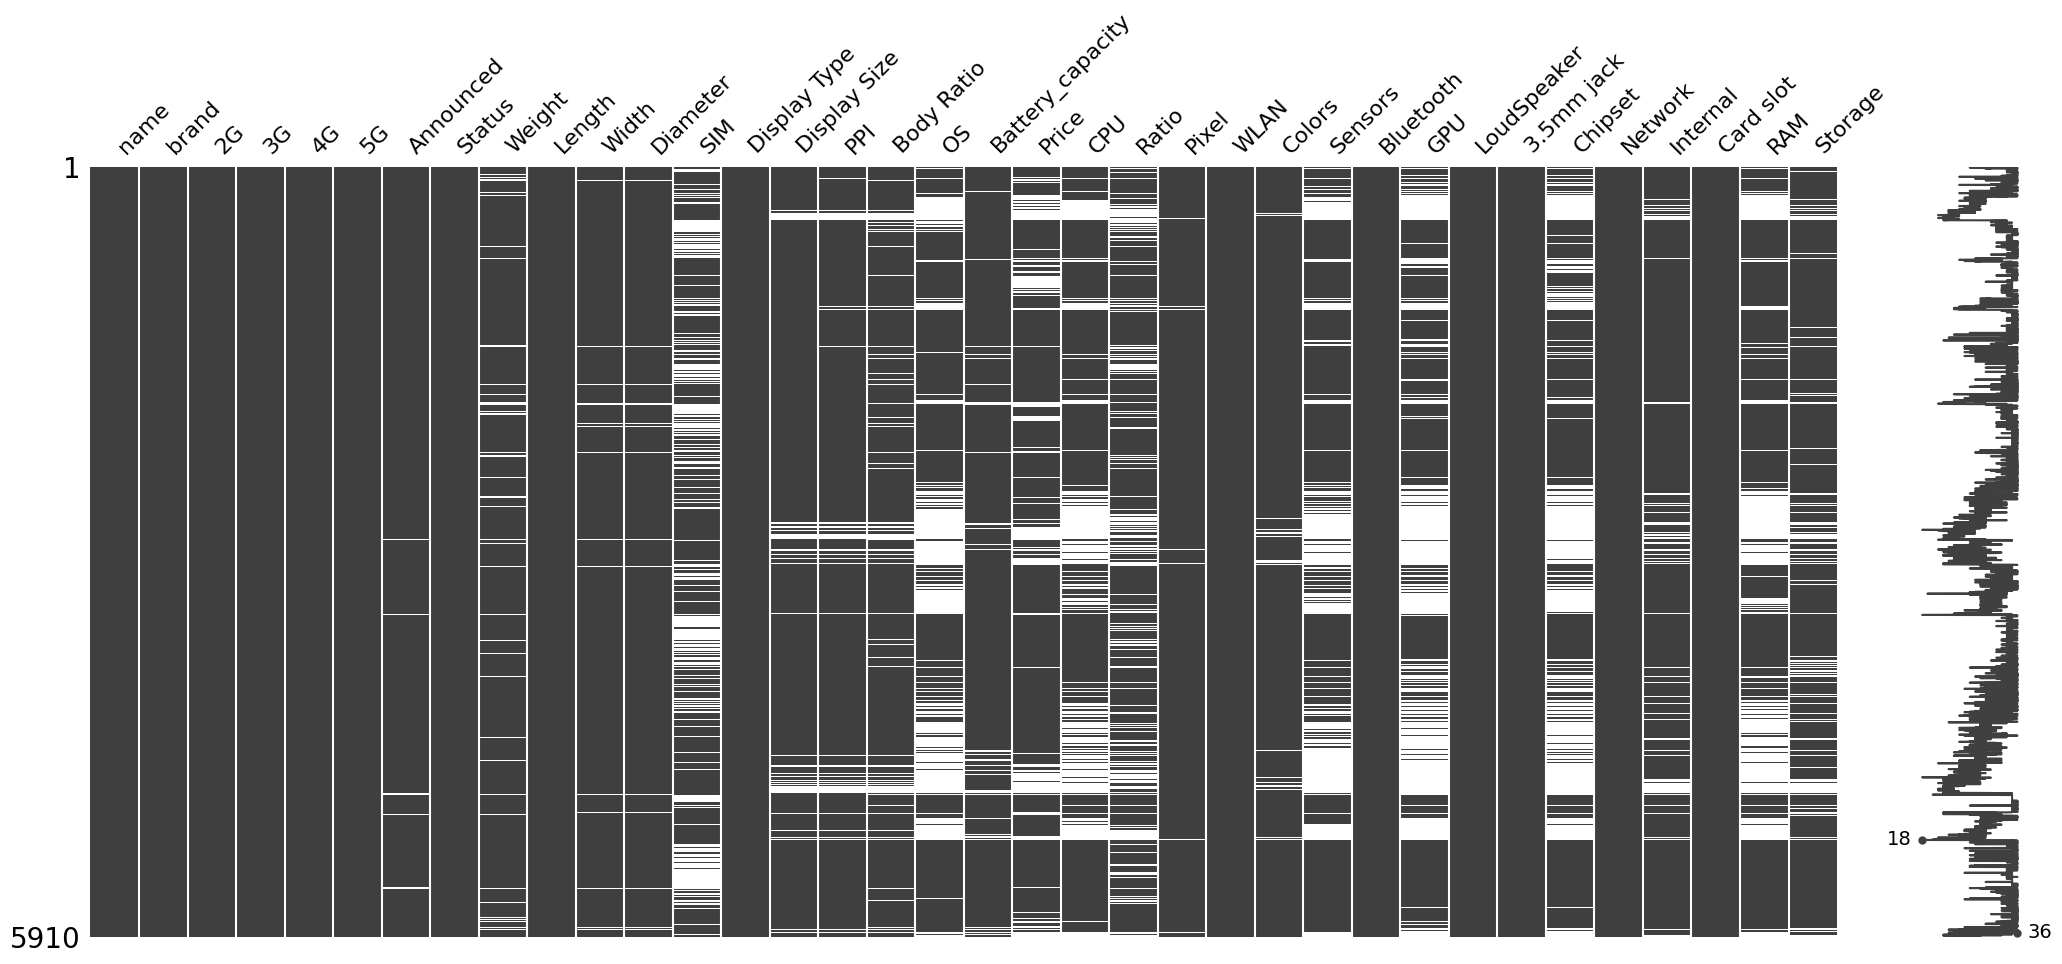

In [103]:
msno.matrix(df)

In [104]:
null_values = df['Price'].isnull().sum() 

In [105]:
null_values # These records don't have price, we can use them for testing phase later; maybe?!

1195

In [106]:
df = df.dropna(subset=['Price'])   # Removed rows with Null value as their price 
df.shape

(4715, 36)

In [107]:
pd.set_option('display.max_rows', None)        # Show all rows  
pd.set_option('display.max_columns', None)     # Show all columns  

In [108]:
pd.set_option('display.max_rows', 10)        # Default Settings  
pd.set_option('display.max_columns', 20)      

In [109]:
def extract_price_in_eur(price_str):  
    usd_pattern = re.compile(r'\$\s*(\d+(\.\d+)?)') 
    gbp_pattern = re.compile(r'£\s*(\d+(\.\d+)?)') 
    inr_pattern = re.compile(r'₹\s*(\d+(\.\d+)?)') 
    
    try:
        # Handle cases with '€' in it initial state
        if '€' in price_str:   
            euro_price = 0
            parts = price_str.split('€')[1]
            parts1 = parts.split(' ')[0]
            price_float = float(parts1.replace(',', '')) 
            return price_float 
        
        # Handle cases with 'About' in it 
        elif 'About' in price_str:  
            if 'BTC' in price_str:
                parts3 = price_str.split(' ')[2]
                parts4 = parts3.split('/')[0]
                return float(parts4) * 94044.08

            else:
                return float(price_str.split(' ')[1])

        # Handle cases with converting $ to €
        elif usd_pattern.search(price_str):  
            return float(usd_pattern.search(price_str).group(1)) * 0.97

        # Handle cases with converting £ to €
        elif gbp_pattern.search(price_str):  
            return float(gbp_pattern.search(price_str).group(1)) * 1.18

         # Handle cases with converting ₹ to €
        elif inr_pattern.search(price_str):  
            inr_price = 0
            parts5 = price_str.split('₹')[1]
            parts6 = parts5.split(' ')[0]
            price_float = float(parts6.replace(',', '')) 
            return price_float * 0.011

    except Exception as e:    
        print(f"An error occurred: {e}")  
        return -1  # Return -1 if no price found or invalid format

In [110]:
df['Price'] = df['Price'].apply(extract_price_in_eur)  

C:\Users\user\AppData\Local\Temp\ipykernel_9808\3150977457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].apply(extract_price_in_eur)


In [111]:
def convert_to_mb(value):
    if pd.isna(value):
        return None
    
    if isinstance(value, str):
        values_mb = []
        for item in value.split(', '):
            match = re.match(r'(\d+)([A-Z]{2})', item)
            if match:
                num, unit = match.groups()
                num = float(num)
                if unit == 'GB':
                    values_mb.append(num * 1024)
                elif unit == 'MB':
                    values_mb.append(num)
                elif unit == 'KB':
                    values_mb.append(num / 1024)
        return ', '.join(map(str, map(int, values_mb))) if values_mb else None
    elif isinstance(value, (int, float)):
        return str(int(value))
    else:
        return None

In [112]:
df['RAM'] = df['RAM'].apply(convert_to_mb)
df['Storage'] = df['Storage'].apply(convert_to_mb)

C:\Users\user\AppData\Local\Temp\ipykernel_9808\502655593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RAM'] = df['RAM'].apply(convert_to_mb)
C:\Users\user\AppData\Local\Temp\ipykernel_9808\502655593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Storage'] = df['Storage'].apply(convert_to_mb)


In [113]:
def extract_year(date_str):
    if re.match(r'^\d{4}$', str(date_str)):
        return int(date_str)
    match = re.search(r'\b\d{4}\b', str(date_str))
    if match:
        return int(match.group())
    return pd.NaT

In [114]:
df['Announced'] = df['Announced'].apply(extract_year)

C:\Users\user\AppData\Local\Temp\ipykernel_9808\3743856404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Announced'] = df['Announced'].apply(extract_year)


In [115]:
# Columns to drop: name, Netwrok, Internal, Status?, OS?
# Categorical Columns which should be labled: brand, Card slot, Storage?, RAM?
# Convertion to number: Battery_capacity
# Logistic Regression

# import statsmodels.api as sm  
# Convert categorical variables to dummy variables  
# df_dummies = pd.get_dummies(df, drop_first=True)  
# X = df_dummies.drop('target', axis=1)  
# y = df_dummies['target']  
# model = sm.Logit(y, X)  
# result = model.fit()  
# print(result.summary())    

In [116]:
# le = LabelEncoder()  

# # Fit and transform the 'brand' column  
# df['brand_label'] = le.fit_transform(df['brand'])  

In [117]:
mean_announced = df.groupby('OS')['Announced'].mean().copy() 

# Fill NaT values in 'Announced' with the mean based on 'OS'  
df['Announced'] = df['Announced'].fillna(df['OS'].map(mean_announced.astype(int)))  

C:\Users\user\AppData\Local\Temp\ipykernel_9808\3410218051.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Announced'] = df['Announced'].fillna(df['OS'].map(mean_announced.astype(int)))


In [118]:
df = df[~df['name'].str.contains('Watch', case=False)]    # Watches should be removed from the dataset

In [119]:
df = df.drop(columns=['Network', 'Internal', 'Ratio', 'OS', 'Colors'])

In [120]:
# Extract numerical part, handling invalid entries by using na=False  
df['Battery_capacity'] = df['Battery_capacity'].str.extract('(\d+)', expand=False)  

# Convert to numeric, forcing errors to NaN  
df['Battery_capacity'] = pd.to_numeric(df['Battery_capacity'], errors='coerce')  

mean_battery_capacity = df.groupby('Display Size')['Battery_capacity'].mean().reset_index()  
mean_battery_capacity = mean_battery_capacity.sort_values(by=['Display Size'], ascending=True)
mean_battery_capacity['Battery_capacity'] = mean_battery_capacity['Battery_capacity'].fillna(method='bfill')

# Convert to Series while keeping only the 'Display Size' as index  
battery_series = mean_battery_capacity.set_index('Display Size')['Battery_capacity']  

# Fill NaN values in 'Battery_capacity' with the mean based on 'Display Size'  
df['Battery_capacity'] = df['Battery_capacity'].fillna(df['Display Size'].map(battery_series.astype(int)))  

In [121]:
def compute_pixel_product(pixel_str):  
    # Check if pixel_str is a string  
    if isinstance(pixel_str, str):    
        width, height = map(int, pixel_str.split(' x '))    
        return width * height  
    return None 

 
df['Pixel'] = df['Pixel'].apply(compute_pixel_product)  

In [122]:
df['Accelerometer'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'accelerometer' in x.lower() else 0)  
df['Fingerprint'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'fingerprint' in x.lower() else 0)  
df['Proximity'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'proximity' in x.lower() else 0)  
df['Compass'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'compass' in x.lower() else 0)  
df['Face ID'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'face id' in x.lower() else 0)  
df['Gyro'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'gyro' in x.lower() else 0)  
df['Barometer'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'barometer' in x.lower() else 0)  
df['Iris Scanner'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'iris scanner' in x.lower() else 0)  
df['Color Spectrum'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'color spectrum' in x.lower() else 0)  
df['Heart Rate'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'heart rate' in x.lower() else 0)  
df['SPO2 ID'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'spo2' in x.lower() else 0)  
df['Temperature'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'temperature' in x.lower() else 0)  
df['UV'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'uv' in x.lower() else 0)  
df['Ambient Light'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'ambient light' in x.lower() else 0)  
df['Humidity'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'humidity' in x.lower() else 0)  
df['Gesture'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'gesture' in x.lower() else 0)  

df = df.drop(columns=['Sensors'])

In [123]:
df['A2DP'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'A2DP' in y else 0)  
df['LE'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'LE' in y else 0)  
df['EDR'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'EDR' in y else 0)  
df['aptX'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'aptX' in y else 0)  
df['L2HC'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'L2HC' in y else 0)  

# Function to extract and convert the Bluetooth version to int  
def convert_bluetooth_to_int(bluetooth_str):   
    bluetooth_str = str(bluetooth_str)  
    try:  
        first_part = bluetooth_str.split(',')[0]  
        return float(first_part)
    except ValueError:  # Handle cases that cannot be converted  
        return 0

df['BT Version'] = df['Bluetooth'].apply(convert_bluetooth_to_int) 

df = df.drop(columns=['Bluetooth'])

In [124]:
df['IPS'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'IPS' in x else 0)  
df['TFT'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'TFT' in x else 0)  
df['AMOLED'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'AMOLED' in x else 0)  
df['OLED'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'OLED' in x else 0)  
df['Super'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'Super' in x else 0)  
df['LCD'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'LCD' in x else 0)  
df['TN'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'TN' in x else 0)  
df['PLS'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'PLS' in x else 0)  
df['LED-backlit'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'LED-backlit' in x else 0)  
df['LTPO'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'LTPO' in x else 0)  

df = df.drop(columns=['Display Type'])

In [125]:
def SIM_label_encoding(sim_value):  
    if pd.isna(sim_value):  
        return 0  
    elif 'nano-sim' in sim_value.lower():  
        return 3  
    elif 'micro-sim' in sim_value.lower():  
        return 2  
    elif 'mini-sim' in sim_value.lower():  
        return 1  
    
df['SIM'] = df['SIM'].map(SIM_label_encoding)  

In [126]:
df['2G'] = df['2G'].astype(int)  
df['3G'] = df['3G'].astype(int)  
df['4G'] = df['4G'].astype(int)  
df['5G'] = df['5G'].astype(int)  

In [127]:
def Status_label_encoding(status_value):  
    if pd.isna(status_value):  
        return -1  
    elif 'Coming' in status_value:
        return 1  
    elif 'Available' in status_value:
        return 1  
    elif 'discontinued' in status_value:
        return 0  
    else:  
        return -1 
    
df['Status'] = df['Status'].map(Status_label_encoding)  

In [128]:
def get_max_storage(storage_value):  
    if pd.isna(storage_value):  # Check for None or NaN  
        return None
    # Split the string by commas, convert to integers, and return the maximum value  
    return max(map(int, storage_value.split(',')))  

df['Storage'] = df['Storage'].apply(get_max_storage)  

In [129]:
def get_max_ram(ram_value):  
    if pd.isna(ram_value):  # Check for None or NaN  
        return None
    # Split the string by commas, convert to integers, and return the maximum value  
    return max(map(int, ram_value.split(',')))  
  
df['RAM'] = df['RAM'].apply(get_max_ram)  

In [130]:
average_price = df.groupby('brand')['Price'].mean().reset_index()  
average_price.sort_values(by=['Price'])

,brand,Price
2,BLU,107.010309
13,alcatel,130.466321
8,Nokia,133.479161
6,LG,142.237354
9,Samsung,198.927086
...,...,...
11,Xiaomi,303.704623
4,Huawei,316.517055
5,Infinix,321.753537
1,Asus,354.908671


In [131]:
def brand_label_encoding(brand_value):  
    if 'Apple' in brand_value: 
        return 13  
    elif 'Asus' in brand_value: 
        return 12
    elif 'Infinix' in brand_value:  
        return 11
    elif 'Huawei' in brand_value: 
        return 10
    elif 'Xiaomi' in brand_value: 
        return 9
    elif 'ZTE' in brand_value:  
        return 8  
    elif 'HTC' in brand_value: 
        return 7  
    elif 'Sony' in brand_value: 
        return 6
    elif 'Lenovo' in brand_value:  
        return 5  
    elif 'Samsung' in brand_value: 
        return 4  
    elif 'LG' in brand_value: 
        return 3
    elif 'Nokia' in brand_value:  
        return 2
    elif 'alcatel' in brand_value: 
        return 1 
    elif 'BLU' in brand_value: 
        return 0
    else:  
        return -1 
    
df['brand'] = df['brand'].apply(brand_label_encoding)  

In [132]:
df['Width'] = pd.to_numeric(df['Width'], errors='coerce')  
df['Length'] = pd.to_numeric(df['Length'], errors='coerce')  

In [133]:
train_df = df.dropna(subset=['Length', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Length']]  
y = train_df['Display Size']  

# Fit the model  
model = LinearRegression()  
model.fit(X, y)  

# Predict missing values  
missing_values = df[df['Display Size'].isnull()]['Length']  

# Reshape missing values for prediction  
predicted_values = model.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Display Size'].isnull(), 'Display Size'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [134]:
train_df = df.dropna(subset=['Length', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Display Size']]  
y = train_df['Length']  

# Fit the model  
model = LinearRegression()  
model.fit(X, y)  

# Predict missing values  
missing_values = df[df['Length'].isnull()]['Display Size']  

# Reshape missing values for prediction  
predicted_values = model.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Length'].isnull(), 'Length'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [135]:
train_df = df.dropna(subset=['Width', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Display Size']]  
y = train_df['Width']  

# Fit the model  
model = LinearRegression()  
model.fit(X, y)  

# Predict missing values  
missing_values = df[df['Width'].isnull()]['Display Size']  

# Reshape missing values for prediction  
predicted_values = model.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Width'].isnull(), 'Width'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [136]:
train_df = df.dropna(subset=['Weight', 'Width'])  

# Prepare the data for regression  
X = train_df[['Width']]  
y = train_df['Weight']  

# Fit the model  
model = LinearRegression()  
model.fit(X, y)  

# Predict missing values  
missing_values = df[df['Weight'].isnull()]['Width']  

# Reshape missing values for prediction  
predicted_values = model.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Weight'].isnull(), 'Weight'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [137]:
train_df = df.dropna(subset=['Body Ratio', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Display Size']]  
y = train_df['Body Ratio']  

# Fit the model  
model = LinearRegression()  
model.fit(X, y)  

# Predict missing values  
missing_values = df[df['Body Ratio'].isnull()]['Display Size']  

# Reshape missing values for prediction  
predicted_values = model.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Body Ratio'].isnull(), 'Body Ratio'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [138]:
train_df = df.dropna(subset=['Diameter', 'Body Ratio'])  

# Prepare the data for regression  
X = train_df[['Body Ratio']]  
y = train_df['Diameter']  

# Fit the model  
model = LinearRegression()  
model.fit(X, y)  

# Predict missing values  
missing_values = df[df['Diameter'].isnull()]['Body Ratio']  

# Reshape missing values for prediction  
predicted_values = model.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Diameter'].isnull(), 'Diameter'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


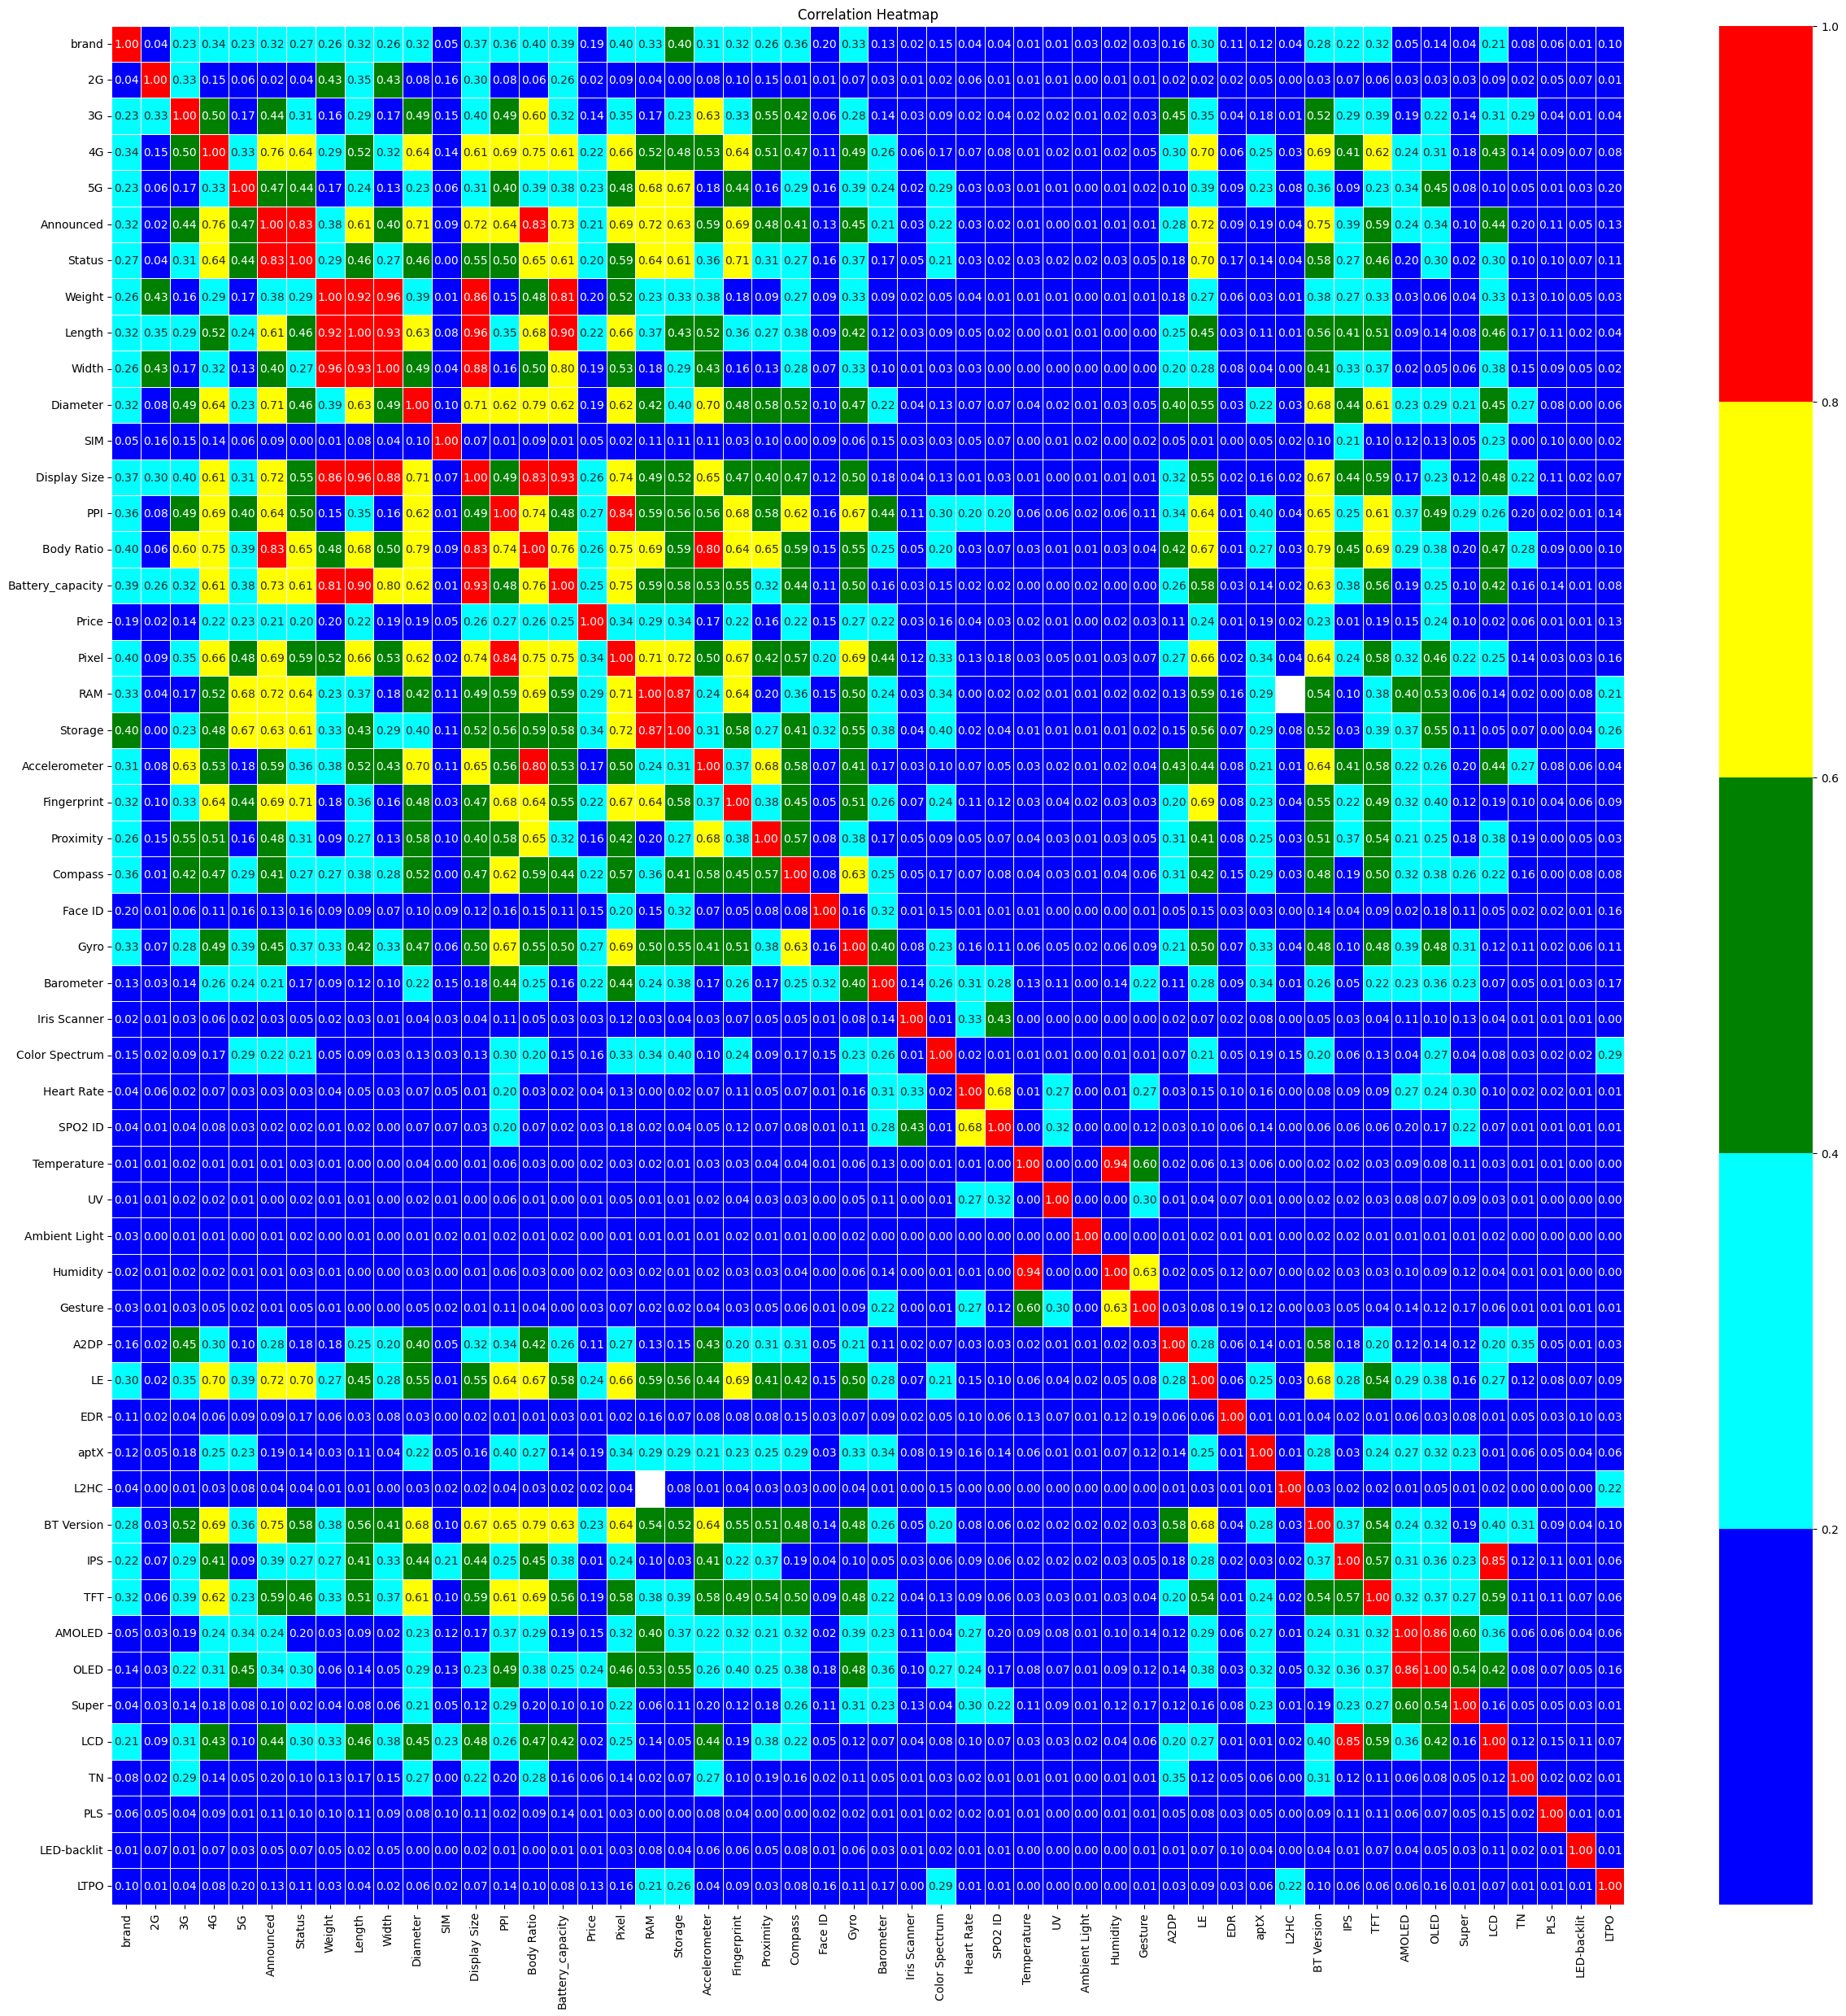

In [139]:
numeric_df = df.select_dtypes(include=[np.number])  

# Calculate the absolute correlation  
corr_df = numeric_df.corr().abs()  

# Plot the heatmap to check the correlation between the variables  
plt.figure(figsize=(30, 30))  
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap=['blue', 'cyan', 'green', 'yellow', 'red'], linewidths=0.5)  
plt.title('Correlation Heatmap')  
plt.show()  

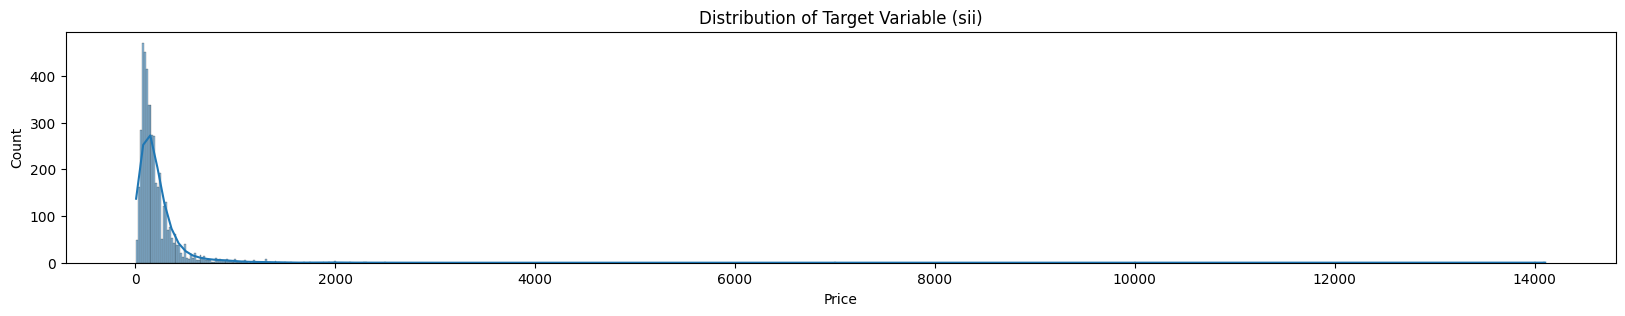

In [140]:
plt.figure(figsize=(20, 3))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Target Variable (sii)')
plt.show()

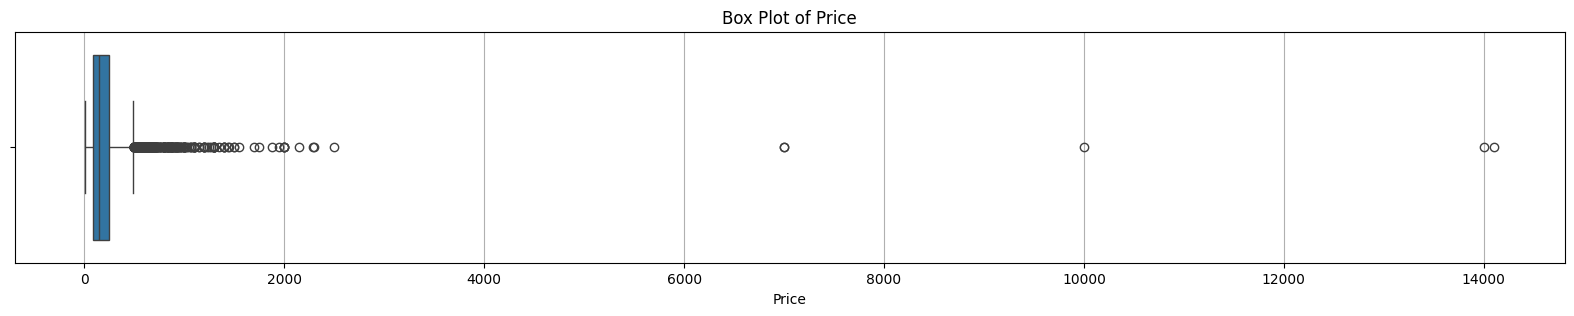

In [141]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=df['Price']) 
plt.title('Box Plot of Price')  
plt.xlabel('Price')  
plt.grid(axis='x')
plt.show()  

<Figure size 1000x500 with 0 Axes>

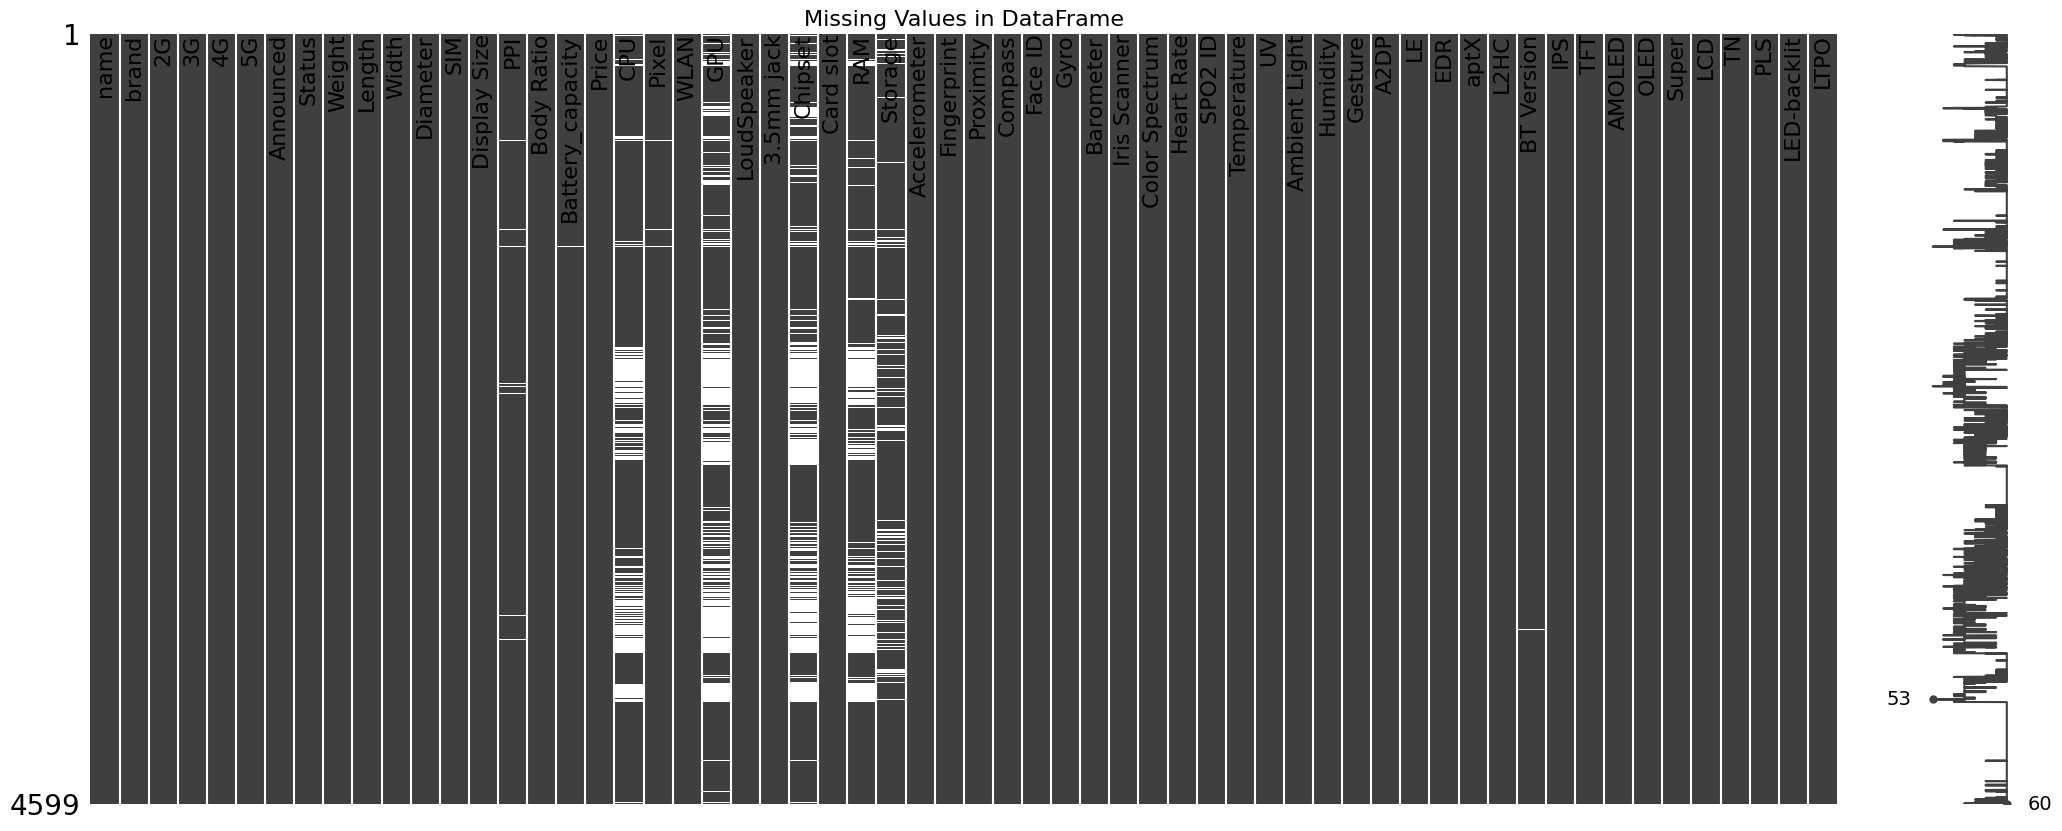

In [142]:
plt.figure(figsize=(10, 5))
msno.matrix(df)  
plt.title('Missing Values in DataFrame', fontsize=16)  

# Get column positions for annotations  
column_labels = df.columns  
num_columns = len(column_labels)  
x_positions = [i for i in range(num_columns)]  

# Annotate each column with its name vertically  
for x, column in zip(x_positions, column_labels):  
    plt.annotate(column, xy=(x, -0.05), ha='center', va='top', fontsize=16, color='black', rotation=90)  

plt.show()  

In [143]:
df

,name,brand,2G,3G,4G,5G,Announced,Status,Weight,Length,...,IPS,TFT,AMOLED,OLED,Super,LCD,TN,PLS,LED-backlit,LTPO
0,1,1,1,1,1,0,2018.0,1,134.000000,137.600000,...,0,1,0,0,0,1,0,0,0,0
1,3,1,1,1,1,0,2018.0,1,145.000000,147.100000,...,1,0,0,0,0,1,0,0,0,0
2,5,1,1,1,1,0,2018.0,1,144.000000,152.300000,...,1,0,0,0,0,1,0,0,0,0
3,7,1,1,1,1,0,2018.0,1,175.000000,162.100000,...,1,0,0,0,0,1,0,0,0,0
5,2001,1,1,0,0,0,2013.0,0,89.000000,112.000000,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,Racer II,8,1,1,0,0,2011.0,0,100.000000,104.000000,...,0,1,0,0,0,0,0,0,0,0
5872,Libra,8,1,1,0,0,2011.0,0,118.512078,119.902978,...,0,1,0,0,0,0,0,0,0,0
5874,Blade,8,1,1,0,0,2010.0,0,110.000000,116.000000,...,0,0,1,1,0,1,0,0,0,0
5886,F107,8,1,1,0,0,2010.0,0,90.000000,105.700000,...,0,1,0,0,0,0,0,0,0,0


# ***Model Training Proccess***

In [144]:
# Assign features and target columns
X = df.select_dtypes(include='number').drop('Price', axis=1) 
y = df['Price']

# Separate train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Separate train and validation data
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [145]:
# Create a Logistic Regression model instance  
model = LogisticRegression()  

# Fit the model on the training data  
model.fit(X_train_val, y_train_val)  

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Evaluate the model on validation data
y_val_pred = model.predict(X_val)

# Calculate evaluation metrics on validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred, average='weighted')
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')
auc_val = roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr', average='weighted')

# Display the evaluations metrics  based on validation data
print("Accuracy:", accuracy_val)
print("Precision:", precision_val)
print("Recall:", recall_val)
print("F1 score:", f1_val)
print("AUC:", auc_val)

In [ ]:
# Confusion Matrix based on validation data
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix based on Validation Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
# Evaluate the model on test data
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics on test data
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
auc_test = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')

# Display the evaluation metrics based on test data
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 score:", f1_test)
print("AUC:", auc_test)

In [ ]:
# Confusion Matrix based on test data
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix based on Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()